In [1]:
import sys
import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import TrainTestSplitTask

import os
import glob
import dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.acolite import ReadAcoliteProduct
from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_mile_lacs'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)

l1c_products = eolx.io.get_products_by_level(sentinel_archives, 'L1C')
l1c_products

[(datetime.datetime(2021, 4, 29, 17, 8, 51),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20210429T170851_N0300_R112_T15TVM_20210429T215623.SAFE'),
 (datetime.datetime(2021, 9, 16, 17, 9, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE'),
 (datetime.datetime(2021, 10, 16, 17, 13, 11),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE'),
 (datetime.datetime(2021, 11, 20, 17, 16, 19),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE'),
 (datetime.datetime(2021, 12, 20, 17, 17, 19),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2B_MSIL1C_20211220T171719_N0301_R112_T15TVM_20211220T192125.SAFE'),
 (datetime.datetime(2022, 1, 19, 17, 16, 29),
  'D:\\sdb_datas

In [3]:
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 4, 29, 17, 8, 51),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20210429T170851_N9999_R112_T15TVM_20220501T111454.SAFE'),
 (datetime.datetime(2021, 4, 29, 17, 8, 51),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20210429T170851_N9999_R112_T15TVM_20220501T170009.SAFE'),
 (datetime.datetime(2021, 10, 16, 17, 13, 11),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [4]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders

['D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20210429T170851_ACOLITE_SUBSET',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20210429T170851_ACOLITE_SUBSET_minus_30_m_buffer_polygon',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211125T171641_ACOLITE_SUBSET']

In [5]:
import_millie_lacs = ImportFromTiffTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    os.path.abspath(os.path.join(data_root_path, 'mille_lacs.tiff')),
)
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
)

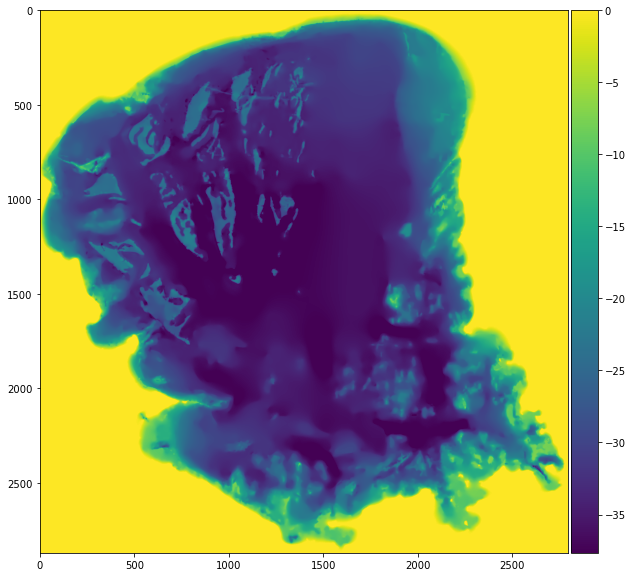

In [6]:
eolx.visualization.plot_single_band(millie_lacs_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')
plt.show()

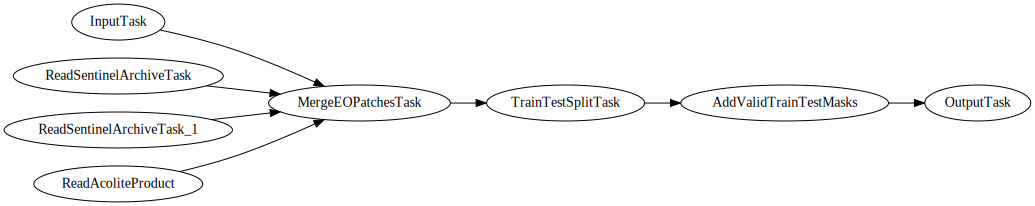

In [7]:
input_bathy_task = InputTask(millie_lacs_eop)
input_bathy_node = EONode(input_bathy_task, inputs=tuple())

height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape

l2a_archive_path = l2a_products[0][1]
read_l2a_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=millie_lacs_eop.bbox
)
read_l2a_node = EONode(read_l2a_eop_task, inputs=tuple())

l1c_archive_path = l1c_products[0][1]
read_l1c_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=millie_lacs_eop.bbox
)
read_l1c_node = EONode(read_l1c_eop_task, inputs=tuple())

acolite_product = 'L2R'
reflectance_type = 'rhos'
acolite_product_path = sentinel_acolite_folders[0]
acolite_data_feature = (FeatureType.DATA, f'{acolite_product}_data')
read_acolite_product_task = ReadAcoliteProduct(
    reference_bbox=millie_lacs_eop.bbox,
    feature=acolite_data_feature,
    acolite_product=acolite_product,
    reflectance_type=reflectance_type
)
read_acolite_node = EONode(read_acolite_product_task, inputs=tuple())

merge_patches_task = MergeEOPatchesTask()
merge_eop_node = EONode(
    merge_patches_task,
    inputs=[input_bathy_node, read_l2a_node, read_l1c_node, read_acolite_node]
)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)
train_test_split_node = EONode(train_test_split_task, inputs=[merge_eop_node])

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

read_merge_wf = EOWorkflow(
    [
        input_bathy_node,
        read_l1c_node,
        read_l2a_node,
        read_acolite_node,
        merge_eop_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node,
    ]
)

read_merge_wf.dependency_graph()

In [8]:
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        read_l2a_node: {'sentinel_archive_path': l2a_archive_path},
        read_l1c_node: {'sentinel_archive_path': l1c_archive_path},
        read_acolite_node: {'acolite_product_folder': acolite_product_path},
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    mission: 'S2A'
    test_count: 1039055
    test_perc: 0.19988842237900803
    train_count: 4159120
    train_perc: 0.8001115776209919
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 4, 29, 17, 8, 51

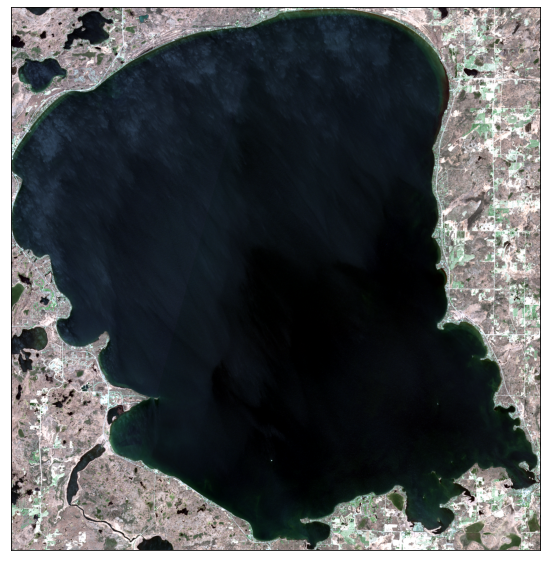

In [9]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L1C_data"),
    stretch=True
)
plt.show()

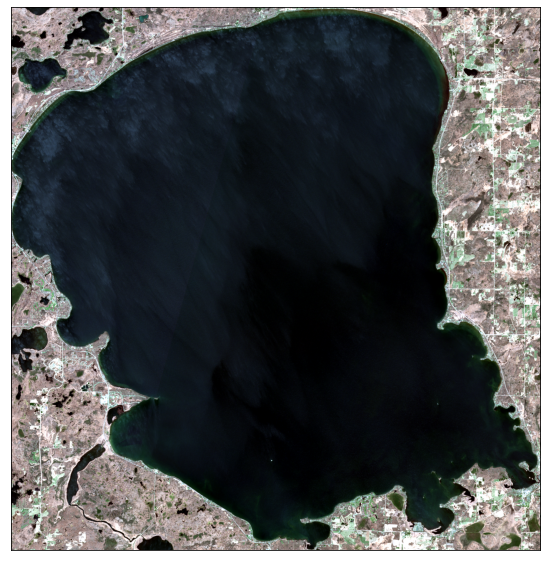

In [10]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)
plt.show()

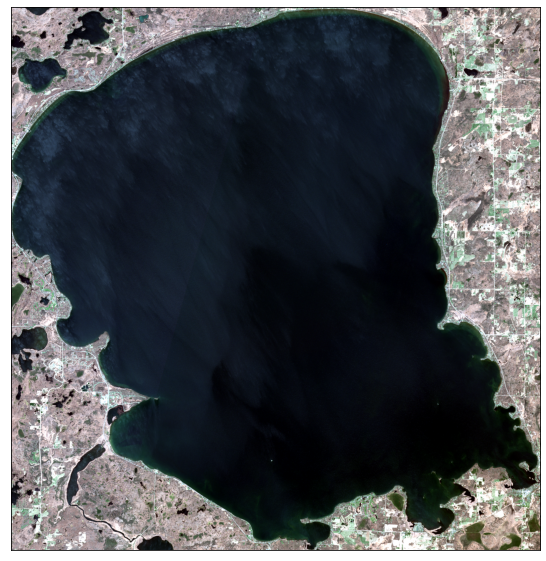

In [11]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, f'{acolite_product}_data'),
    stretch=True
)
plt.show()

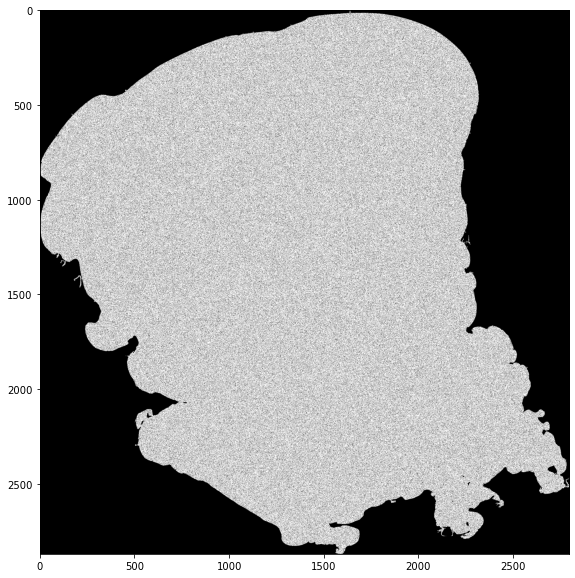

In [12]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False)
plt.show()

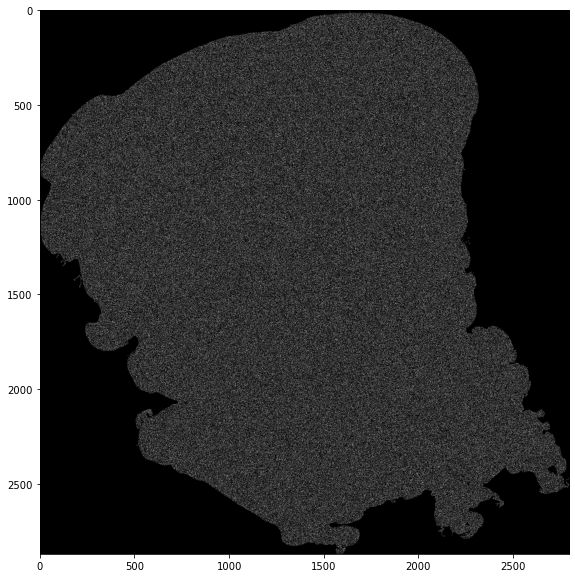

In [13]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False)
plt.show()

### L1C Testing

In [14]:
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

X_train.shape, y_train.shape

((4159120, 13), (4159120,))

In [15]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-4.578629867553865, 0.00226260928951427)

In [16]:
model = LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [17]:
X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

X_test.shape, y_test.shape

((1039055, 13), (1039055,))

In [18]:
y_hat_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_hat_test))

4.58473010067861

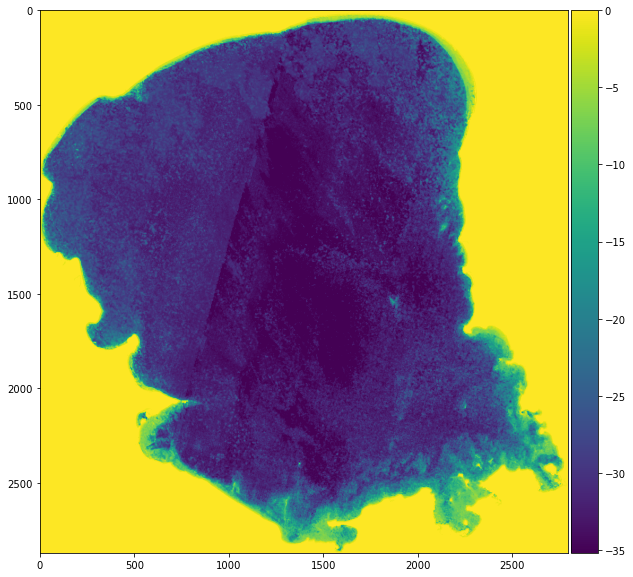

In [19]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l1c_sdb_estimation_values, l1c_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)
eolx.visualization.plot_ndarray_band(l1c_sdb_estimation_map, cmap='viridis')
plt.show()

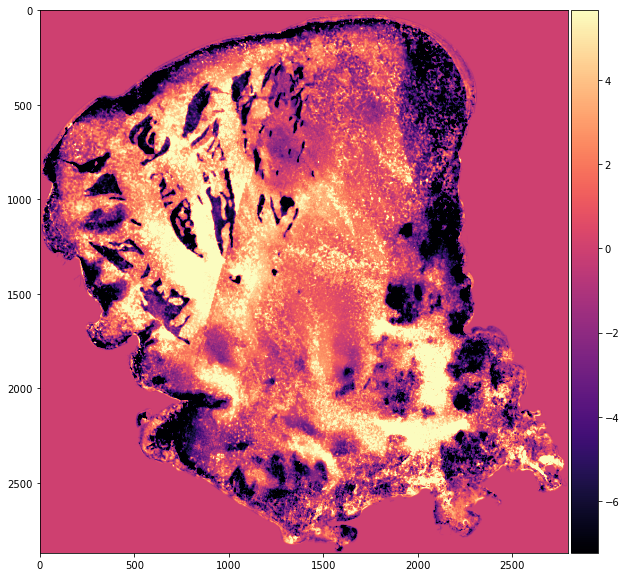

In [20]:
l1c_sdb_errors = l1c_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(l1c_sdb_errors, cmap='magma')
plt.show()

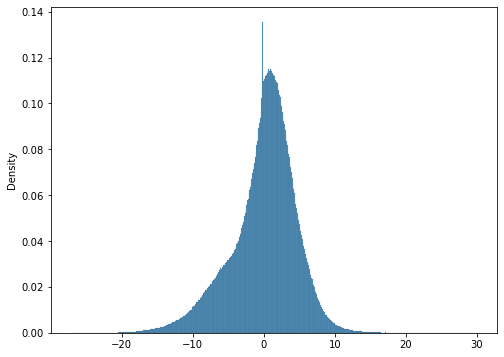

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all
sns.histplot(l1c_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

### L2A Testing

In [22]:
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-4.483390065090859, 0.006713267792943262)

In [23]:
model = LGBMRegressor()
model.fit(X_train, y_train)

X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

y_hat_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_hat_test))

4.486776483602259

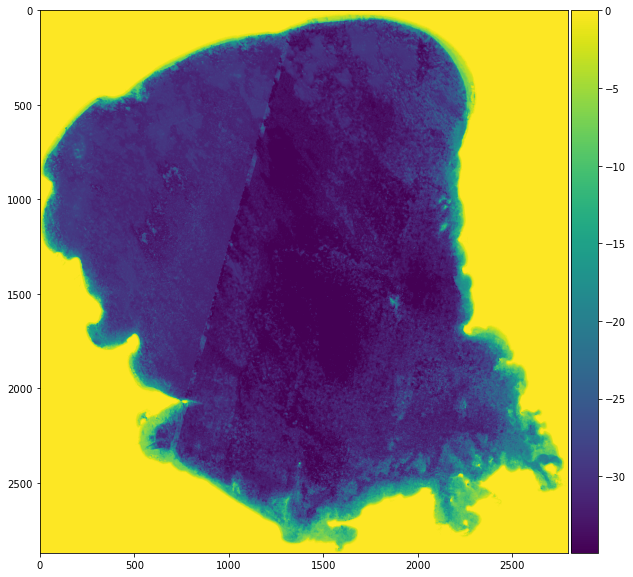

In [24]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

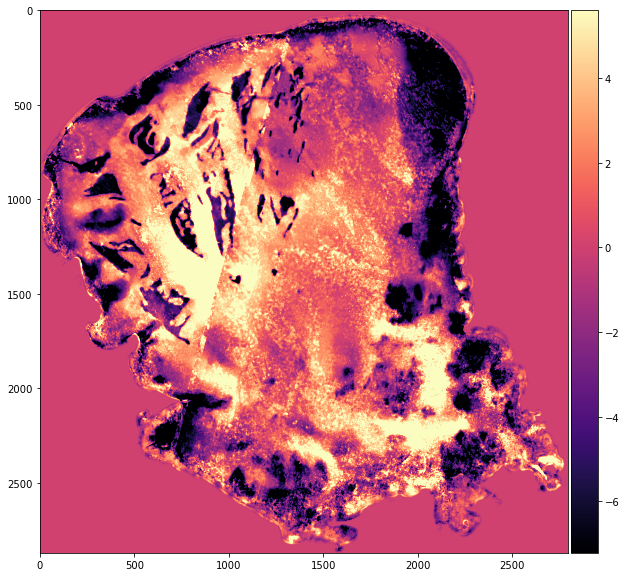

In [25]:
l2a_sdb_errors = l2a_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

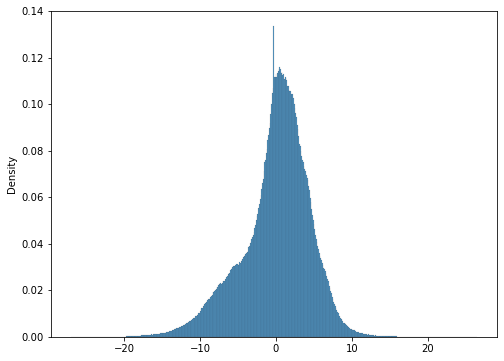

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

### Acolite Testing

In [27]:
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-5.2884566477345825, 0.0025933398281980558)

In [28]:
model = LGBMRegressor()
model.fit(X_train, y_train)

X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

y_hat_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_hat_test))

5.292888307336804

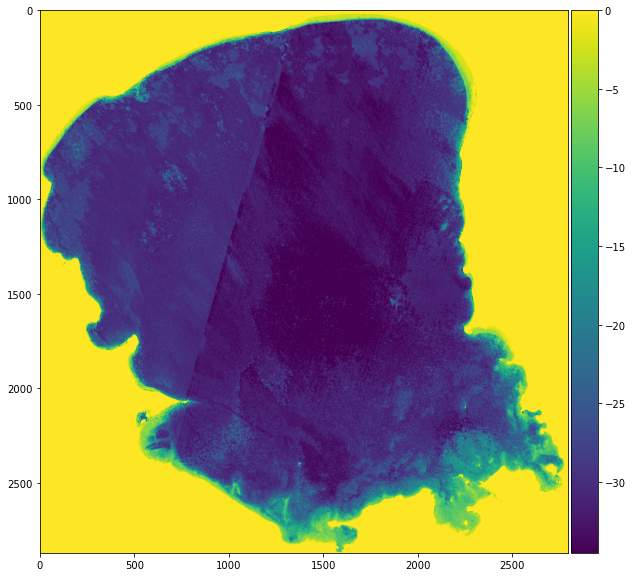

In [29]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)
eolx.visualization.plot_ndarray_band(acolite_sdb_estimation_map, cmap='viridis')
plt.show()

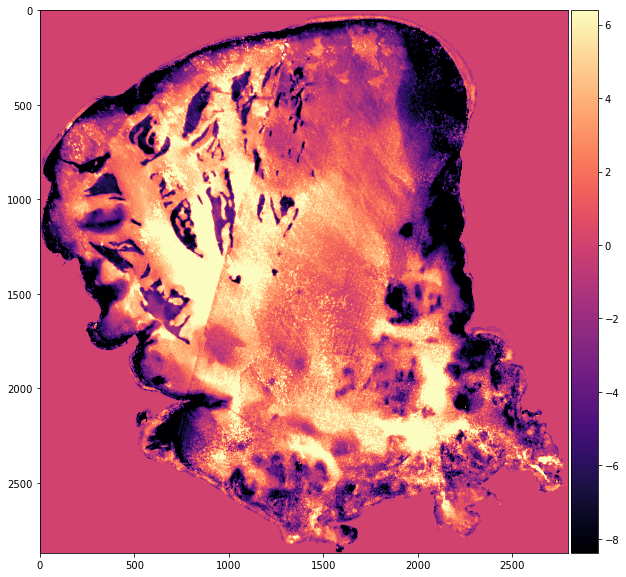

In [30]:
acolite_sdb_errors = acolite_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

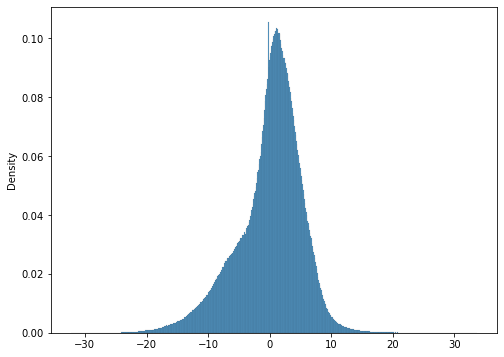

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()